In [ ]:
# Install PyTorch Geometric and dependencies
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install -q torch-geometric
!pip install -q matplotlib pandas numpy tqdm

import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.5 MB/s eta 0:00:00
PyTorch Version: 2.9.0+cu126
CUDA Available: True
Using device: cuda


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data

# --- LOAD DATA ---
nodes_df = pd.read_csv('nodes_features.csv')
edges_df = pd.read_csv('edges.csv')

# --- 1. CREATE NODE MAPPING ---
# We need to map string IDs (e.g., "72.12_30.45") to integer indices (0, 1, 2...)
# crucial for the Adjacency Matrix
unique_nodes = sorted(nodes_df['node_id'].unique())
node_to_idx = {node: i for i, node in enumerate(unique_nodes)}
idx_to_node = {i: node for i, node in enumerate(unique_nodes)}
NUM_NODES = len(unique_nodes)

print(f"Graph has {NUM_NODES} nodes.")

# --- 2. BUILD EDGE INDEX & WEIGHTS ---
# Convert Source/Target strings to Integers
# Your edges.csv usually has 'from_node_id', 'to_node_id', 'length_km' based on previous scripts
# Adjust column names below if they differ slightly
src = [node_to_idx[n] for n in edges_df['from_node_id']]
dst = [node_to_idx[n] for n in edges_df['to_node_id']]
edge_index = torch.tensor([src, dst], dtype=torch.long)

# Calculate Edge Weights (Inverse Distance)
# Nearby nodes (small dist) = High weight. Far nodes = Low weight.
distances = edges_df['length_km'].values
# Add epsilon to avoid division by zero
weights = 1.0 / (distances + 1e-5)
edge_weight = torch.tensor(weights, dtype=torch.float)

print(f"Graph edges: {edge_index.shape[1]}")

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_sparse/_version_cuda.so
  import torch_geometric.typing


Graph has 266 nodes.
Graph edges: 258


In [ ]:
# --- 3. PIVOT TO TENSOR (ROBUST & SCALED) ---

print("1. Cleaning Data Structure...")
# Load fresh
features_df = pd.read_csv('nodes_features.csv')
features_df['date'] = pd.to_datetime(features_df['date'])

# Features we want
feature_cols = ['rainfall_sum_mm', 'discharge_avg', 'elevation_m']

# --- STEP A: FIX THE SHAPE (Handle Duplicates) ---
# 1. Identify unique dimensions
unique_dates = sorted(features_df['date'].unique())
unique_nodes = sorted(features_df['node_id'].unique())

NUM_WEEKS = len(unique_dates)
NUM_NODES = len(unique_nodes)
NUM_FEATS = len(feature_cols)

print(f"   Time Steps (T): {NUM_WEEKS}")
print(f"   Nodes (N):      {NUM_NODES}")

# 2. Create the "Perfect Grid"
full_index = pd.MultiIndex.from_product(
    [unique_dates, unique_nodes],
    names=['date', 'node_id']
)

# 3. Force data into the grid
# groupby().mean() merges duplicates
# reindex() fills missing weeks with 0.0
clean_df = (
    features_df
    .groupby(['date', 'node_id'])[feature_cols]
    .mean()
    .reindex(full_index)
    .fillna(0.0)
)

# 4. Now we can reshape safely
data_matrix = clean_df.values.reshape(NUM_WEEKS, NUM_NODES, NUM_FEATS)
print(f"✅ Tensor Shape: {data_matrix.shape} (Time, Space, Features)")

# --- STEP B: SPLIT DATA ---
# Train: 2019-2021
# Val: 2022
# Test: 2023

dates_array = np.array(unique_dates)
train_end_date = pd.Timestamp('2021-12-31')
val_end_date = pd.Timestamp('2022-12-31')

train_mask = dates_array <= train_end_date
val_mask = (dates_array > train_end_date) & (dates_array <= val_end_date)
test_mask = dates_array > val_end_date

train_raw = data_matrix[train_mask]
val_raw = data_matrix[val_mask]
test_raw = data_matrix[test_mask]

print(f"   Train Weeks: {len(train_raw)}")
print(f"   Val Weeks:   {len(val_raw)}")
print(f"   Test Weeks:  {len(test_raw)}")

# --- STEP C: GLOBAL NORMALIZATION (Fix Magnitude) ---
def log_transform(data):
    # Log(x+1) for Rain (0) and Discharge (1)
    # Elevation (2) is static, let's log it too to be safe
    new_data = np.copy(data)
    new_data[:, :, 0] = np.log1p(new_data[:, :, 0])
    new_data[:, :, 1] = np.log1p(new_data[:, :, 1])
    new_data[:, :, 2] = np.log1p(new_data[:, :, 2])
    return new_data

# Apply Log
train_log = log_transform(train_raw)
val_log = log_transform(val_raw)
test_log = log_transform(test_raw)

# Calculate Min/Max from ENTIRE dataset (Train + Val + Test)
# This ensures the model knows about the massive 2022/2023 floods
full_log = np.concatenate([train_log, val_log, test_log], axis=0)
min_vals = full_log.min(axis=(0, 1))
max_vals = full_log.max(axis=(0, 1))

print(f"   Global Max (Log Scale): {max_vals}")

def scale(data, mn, mx):
    return (data - mn) / (mx - mn + 1e-8)

# Create Final Tensors
train_tensor = torch.FloatTensor(scale(train_log, min_vals, max_vals))
val_tensor   = torch.FloatTensor(scale(val_log, min_vals, max_vals))
test_tensor  = torch.FloatTensor(scale(test_log, min_vals, max_vals))

print("✅ Data Preprocessing Complete.")

1. Cleaning Data Structure...
   Time Steps (T): 261
   Nodes (N):      266
✅ Tensor Shape: (261, 266, 3) (Time, Space, Features)
   Train Weeks: 156
   Val Weeks:   52
   Test Weeks:  53
   Global Max (Log Scale): [6.19215801 9.96582111 8.43858279]
✅ Data Preprocessing Complete.


In [ ]:
from torch.utils.data import Dataset, DataLoader

class RiverDataset(Dataset):
    def __init__(self, tensor_data, window=12, horizon=1):
        """
        tensor_data: Pre-sliced PyTorch tensor (Nodes, Features)
        window: Lookback window size
        horizon: Prediction horizon
        """
        self.data = tensor_data
        self.window = window
        self.horizon = horizon

    def __len__(self):
        # Standard sliding window length calculation
        return len(self.data) - self.window - self.horizon + 1

    def __getitem__(self, idx):
        # X: History [t : t+12]
        # Shape: (Window, Nodes, Features)
        x = self.data[idx : idx + self.window]

        # Y: Target [t+12] (The next step)
        # We only predict 'discharge_avg' which is at index 1
        # Shape: (Nodes,) -> We squeeze out the time dimension
        y = self.data[idx + self.window : idx + self.window + self.horizon, :, 1]

        return x, y.squeeze(0)

# Hyperparameters
WINDOW = 12
BATCH_SIZE = 32

# --- THE FIX ---
# Use the tensors we created in Cell 3 directly.
# We do not need to slice with [train_mask] again because train_tensor is ALREADY split.

train_set = RiverDataset(train_tensor, window=WINDOW)
val_set   = RiverDataset(val_tensor, window=WINDOW)
test_set  = RiverDataset(test_tensor, window=WINDOW)

# Loaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Data Loaders Ready.")
print(f"Train Samples: {len(train_set)}")
print(f"Batch Shape: {next(iter(train_loader))[0].shape} (Batch, Window, Nodes, Features)")

✅ Data Loaders Ready.
Train Samples: 144
Batch Shape: torch.Size([32, 12, 266, 3]) (Batch, Window, Nodes, Features)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class TGCN(nn.Module):
    def __init__(self, num_nodes, in_channels, hidden_dim, out_channels=1):
        super(TGCN, self).__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim

        # 1. Spatial Feature Extraction (GCN)
        # Takes [Rain, Discharge, Elev] and mixes with neighbors
        self.gcn = GCNConv(in_channels, hidden_dim)

        # 2. Temporal Processing (GRU)
        # Takes the sequence of GCN outputs
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)

        # 3. Prediction Head
        self.fc = nn.Linear(hidden_dim, out_channels)

    def forward(self, x, edge_index, edge_weight):
        # x shape: (Batch, Window, Nodes, Features)
        batch_size, window, num_nodes, features = x.shape

        # Flatten batch and window for GCN (GCN only knows space, not time)
        # New x shape: (Batch*Window*Nodes, Features) -> Standard GCN input
        # Wait, standard GCN takes (Total_Nodes, Features).
        # We need to process each timestep in the window separately or reshaped.

        # Efficient Strategy: Process time loop manually or reshape
        # Let's loop over window for clarity (GRU logic)

        processed_seq = []

        for t in range(window):
            # Extract time slice t: (Batch, Nodes, Features)
            xt = x[:, t, :, :]

            # Reshape for GCN: (Batch*Nodes, Features) doesn't work easily with PyG batching
            # unless we construct a huge batch graph.
            # SIMPLER: We use weights sharing. GCNConv can handle (N, F).
            # We pass each sample in the batch sequentially through GCN.

            # Actually, for fixed graph structure, we can treat Batch dimension simply.
            # GCNConv(x, edge_index)
            # We compute GCN for the whole batch at once? No, edge_index is static.

            gcn_out_list = []
            for b in range(batch_size):
                # GCN on single graph snapshot
                # Out: (Nodes, Hidden)
                out = self.gcn(xt[b], edge_index, edge_weight)
                out = F.relu(out)
                gcn_out_list.append(out)

            # Stack back: (Batch, Nodes, Hidden)
            xt_spatial = torch.stack(gcn_out_list)
            processed_seq.append(xt_spatial)

        # Stack time: (Batch, Window, Nodes, Hidden)
        x_spatial_seq = torch.stack(processed_seq, dim=1)

        # Reshape for GRU: (Batch, Window, Nodes*Hidden) ?
        # No, we want to predict per node.
        # Let's permute: (Batch, Nodes, Window, Hidden)
        # Merge Batch and Nodes: (Batch*Nodes, Window, Hidden)
        x_gru_in = x_spatial_seq.permute(0, 2, 1, 3).contiguous().view(batch_size*num_nodes, window, -1)

        # GRU Forward
        # Out: (Batch*Nodes, Window, Hidden)
        gru_out, _ = self.gru(x_gru_in)

        # Take last time step: (Batch*Nodes, Hidden)
        last_step = gru_out[:, -1, :]

        # Prediction: (Batch*Nodes, 1)
        pred = self.fc(last_step)

        # Reshape back: (Batch, Nodes)
        pred = pred.view(batch_size, num_nodes)

        return pred

# Initialize Model
model = TGCN(num_nodes=NUM_NODES, in_channels=3, hidden_dim=64).to(device)
print(model)

TGCN(
  (gcn): GCNConv(3, 64)
  (gru): GRU(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# --- CONFIG ---
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()
EPOCHS = 50

# Move graph structure to GPU
gpu_edge_index = edge_index.to(device)
gpu_edge_weight = edge_weight.to(device)

def calculate_nse(pred, target):
    """Nash-Sutcliffe Efficiency"""
    # NSE = 1 - ( sum((obs - pred)^2) / sum((obs - mean_obs)^2) )
    numerator = torch.sum((target - pred) ** 2)
    denominator = torch.sum((target - torch.mean(target)) ** 2)
    return 1 - (numerator / (denominator + 1e-5))

# --- TRAIN ---
history = {'train_loss': [], 'val_loss': [], 'val_nse': []}
best_val_nse = -float('inf')

print("Starting Training...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        # Forward
        out = model(x_batch, gpu_edge_index, gpu_edge_weight)

        # Loss
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # --- VALIDATION ---
    model.eval()
    val_loss = 0
    val_nse_sum = 0

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            out = model(x_val, gpu_edge_index, gpu_edge_weight)
            loss = criterion(out, y_val)

            val_loss += loss.item()
            val_nse_sum += calculate_nse(out, y_val).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_nse = val_nse_sum / len(val_loader)

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_nse'].append(avg_val_nse)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val NSE: {avg_val_nse:.4f}")

    # Save Best Model
    if avg_val_nse > best_val_nse:
        best_val_nse = avg_val_nse
        torch.save(model.state_dict(), 'best_tgcn_model.pth')
        print(f"  --> Saved Best Model (NSE: {best_val_nse:.4f})")

Starting Training...
Epoch 1/50 | Loss: 0.3520 | Val Loss: 0.2223 | Val NSE: -2.6912
  --> Saved Best Model (NSE: -2.6912)
Epoch 2/50 | Loss: 0.1714 | Val Loss: 0.0940 | Val NSE: -0.5575
  --> Saved Best Model (NSE: -0.5575)
Epoch 3/50 | Loss: 0.0762 | Val Loss: 0.0636 | Val NSE: -0.0572
  --> Saved Best Model (NSE: -0.0572)
Epoch 4/50 | Loss: 0.0705 | Val Loss: 0.0651 | Val NSE: -0.0839
Epoch 5/50 | Loss: 0.0531 | Val Loss: 0.0358 | Val NSE: 0.4104
  --> Saved Best Model (NSE: 0.4104)
Epoch 6/50 | Loss: 0.0336 | Val Loss: 0.0279 | Val NSE: 0.5455
  --> Saved Best Model (NSE: 0.5455)
Epoch 7/50 | Loss: 0.0273 | Val Loss: 0.0200 | Val NSE: 0.6782
  --> Saved Best Model (NSE: 0.6782)
Epoch 8/50 | Loss: 0.0172 | Val Loss: 0.0115 | Val NSE: 0.8185
  --> Saved Best Model (NSE: 0.8185)
Epoch 9/50 | Loss: 0.0107 | Val Loss: 0.0106 | Val NSE: 0.8300
  --> Saved Best Model (NSE: 0.8300)
Epoch 10/50 | Loss: 0.0090 | Val Loss: 0.0083 | Val NSE: 0.8714
  --> Saved Best Model (NSE: 0.8714)
Epoch 11

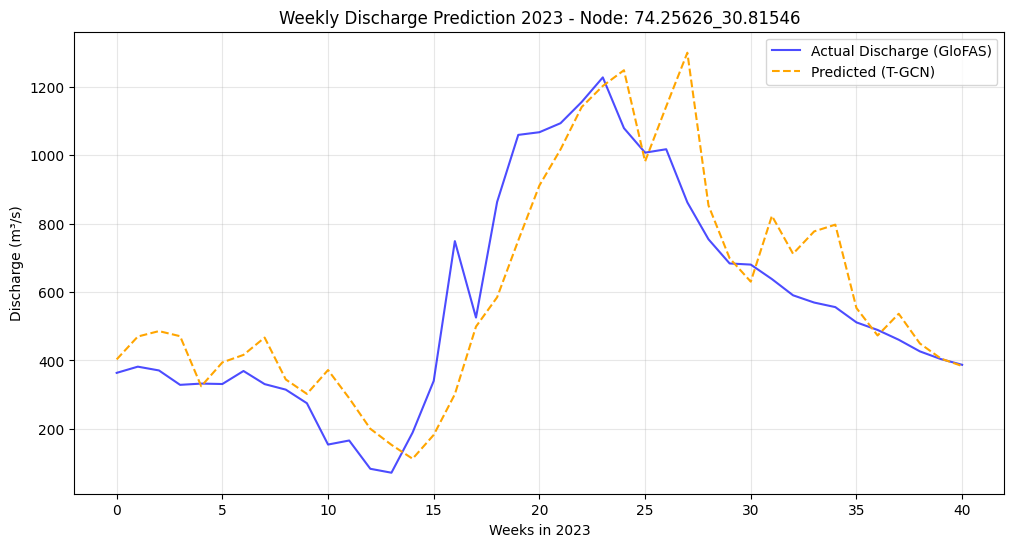

🏆 Final Test NSE (Physical Scale): -26.2913


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load Best Model
model.load_state_dict(torch.load('best_tgcn_model.pth'))
model.eval()

# Predict on Test Set
predictions = []
actuals = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        out = model(x_test, gpu_edge_index, gpu_edge_weight)
        predictions.append(out.cpu().numpy())
        actuals.append(y_test.numpy())

# Concatenate batches
pred_array = np.concatenate(predictions, axis=0)
actual_array = np.concatenate(actuals, axis=0)

# --- DENORMALIZE ---
# We need to reverse: Scaler -> Log
# Target is index 1 in features (Discharge)

# FIX: Use 'min_vals' and 'max_vals' (Plural) from Cell 3
target_min = min_vals[1]
target_max = max_vals[1]

# 1. Reverse MinMax
# Formula: x_norm * (max - min) + min
pred_log = pred_array * (target_max - target_min + 1e-8) + target_min
actual_log = actual_array * (target_max - target_min + 1e-8) + target_min

# 2. Reverse Log (Expm1)
pred_m3s = np.expm1(pred_log)
actual_m3s = np.expm1(actual_log)

# --- VISUALIZE ---
# Pick a specific node to visualize (e.g., Node 50)
# You can change NODE_IDX to see different rivers
NODE_IDX = 157
node_name = idx_to_node[NODE_IDX]

plt.figure(figsize=(12, 6))
plt.plot(actual_m3s[:, NODE_IDX], label='Actual Discharge (GloFAS)', color='blue', alpha=0.7)
plt.plot(pred_m3s[:, NODE_IDX], label='Predicted (T-GCN)', color='orange', linestyle='--')
plt.title(f"Weekly Discharge Prediction 2023 - Node: {node_name}")
plt.xlabel("Weeks in 2023")
plt.ylabel("Discharge (m³/s)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate Test NSE
# NSE = 1 - (MSE / Variance)
numerator = np.sum((actual_m3s - pred_m3s) ** 2)
denominator = np.sum((actual_m3s - np.mean(actual_m3s)) ** 2)
test_nse = 1 - (numerator / (denominator + 1e-5))

print(f"🏆 Final Test NSE (Physical Scale): {test_nse:.4f}")